[[Python] Keras-RLで簡単に強化学習(DQN)を試す](http://qiita.com/inoory/items/e63ade6f21766c7c2393)を試す。

実行時に、以下の警告ログが出た。TensorFlowを高速化できるようである。

[How to compile Tensorflow with SSE4.2 and AVX instructions?](http://stackoverflow.com/questions/41293077/how-to-compile-tensorflow-with-sse4-2-and-avx-instructions)

```
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE3 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
```

In [2]:
import gym
import gym.spaces
import numpy as np

# 直線上を動く点の速度を操作し、目標(原点)に移動させることを目標とする環境
class PointOnLine(gym.core.Env):
    def __init__(self):
        self.action_space = gym.spaces.Discrete(3) # 行動空間。速度を下げる、そのまま、上げるの3種

        high = np.array([1.0, 1.0]) # 観測空間(state)の次元 (位置と速度の2次元) とそれらの最大値
        self.observation_space = gym.spaces.Box(low=-high, high=high) # 最小値は、最大値のマイナスがけ

    # 各stepごとに呼ばれる
    # actionを受け取り、次のstateとreward、episodeが終了したかどうかを返すように実装
    def _step(self, action):
        # actionを受け取り、次のstateを決定
        dt = 0.1
        acc = (action - 1) * 0.1
        self._vel += acc * dt
        self._vel = max(-1.0,  min(self._vel, 1.0))
        self._pos += self._vel * dt
        self._pos = max(-1.0,  min(self._pos, 1.0))

        # 位置と速度の絶対値が十分小さくなったらepisode終了
        done = abs(self._pos) < 0.1 and abs(self._vel) < 0.1

        if done:
            # 終了したときに正の報酬
            reward = 1.0
        else:
            # 時間経過ごとに負の報酬
            # ゴールに近づくように、距離が近くなるほど絶対値を減らしておくと、学習が早く進む
            reward = -0.01 * abs(self._pos)

        # 次のstate、reward、終了したかどうか、追加情報の順に返す
        # 追加情報は特にないので空dict
        return np.array([self._pos, self._vel]), reward, done, {}

    # 各episodeの開始時に呼ばれ、初期stateを返すように実装
    def _reset(self):
        # 初期stateは、位置はランダム、速度ゼロ
        self._pos = np.random.rand()*2 - 1
        self._vel = 0.0
        return np.array([self._pos, self._vel])

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

env = PointOnLine()
nb_actions = env.action_space.n

# DQNのネットワーク定義
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# experience replay用のmemory
memory = SequentialMemory(limit=50000, window_length=1)
# 行動方策はオーソドックスなepsilon-greedy。ほかに、各行動のQ値によって確率を決定するBoltzmannQPolicyが利用可能
policy = EpsGreedyQPolicy(eps=0.1) 
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=100,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

history = dqn.fit(env, nb_steps=50000, visualize=False, verbose=2, nb_max_episode_steps=300)
#学習の様子を描画したいときは、Envに_render()を実装して、visualize=True にします,

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                48        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_3 (Activation)    (None, 16)                0         
__________

Testing for 10 episodes ...
Episode 1: reward: 0.995, steps: 6
Episode 2: reward: 0.715, steps: 60
Episode 3: reward: 0.778, steps: 53
Episode 4: reward: 0.839, steps: 41
Episode 5: reward: 0.844, steps: 46
Episode 6: reward: 0.678, steps: 62
Episode 7: reward: 0.906, steps: 33
Episode 8: reward: 1.000, steps: 1
Episode 9: reward: 0.889, steps: 39
Episode 10: reward: 0.958, steps: 23


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


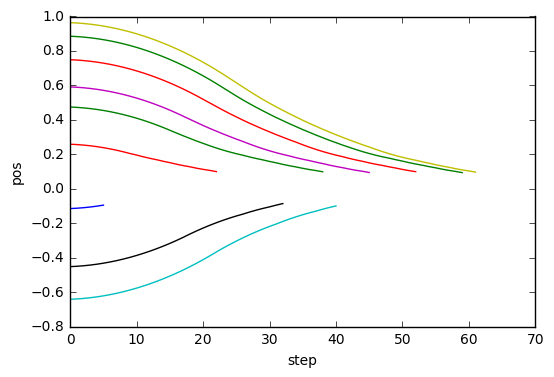

In [4]:
import rl.callbacks
class EpisodeLogger(rl.callbacks.Callback):
    def __init__(self):
        self.observations = {}
        self.rewards = {}
        self.actions = {}

    def on_episode_begin(self, episode, logs):
        self.observations[episode] = []
        self.rewards[episode] = []
        self.actions[episode] = []

    def on_step_end(self, step, logs):
        episode = logs['episode']
        self.observations[episode].append(logs['observation'])
        self.rewards[episode].append(logs['reward'])
        self.actions[episode].append(logs['action'])

cb_ep = EpisodeLogger()
dqn.test(env, nb_episodes=10, visualize=False, callbacks=[cb_ep])


%matplotlib inline
import matplotlib.pyplot as plt

for obs in cb_ep.observations.values():
    plt.plot([o[0] for o in obs])
plt.xlabel("step")
plt.ylabel("pos")